# 00 Wandasとは何か
## 信号処理・音響解析のための新しいアプローチ

このノートブックでは、**なぜWandasが必要なのか**を説明し、信号処理の課題とWandasがどのように解決するかを紹介します。

**学習目標:**
- 信号処理の現状と課題を理解する
- Wandasの特徴と利点を把握する
- どんな問題を解決できるかを知る
- 最初の動機付けを得る

In [1]:
import wandas as wd
import matplotlib.pyplot as plt


## 🎯 信号処理の現状と課題

### 従来の信号処理の難しさ

音響・振動データの解析では、以下のような課題があります：

#### 1. **複雑なツールチェーン**

**問題点:**
- 複数のライブラリを組み合わせる必要がある
- 各ステップでデータの形状を意識する必要がある
- エラーが発生しやすい
- コードが冗長になる

#### 2. **データ管理の複雑さ**

- **多次元データの扱い**: チャンネル数、サンプリングレート、時間軸の管理
- **メモリ効率**: 大規模データの処理
- **メタデータ**: 単位、チャンネル名、処理履歴の管理
- **型安全性**: NumPy配列のdtype管理

#### 3. **再現性と保守性の欠如**

- **処理履歴の追跡**: どのような処理を施したか分からない
- **パラメータ管理**: フィルタ係数、サンプリングレートなどの管理
- **ドキュメント化**: 分析プロセスの再現が難しい

#### 従来の例

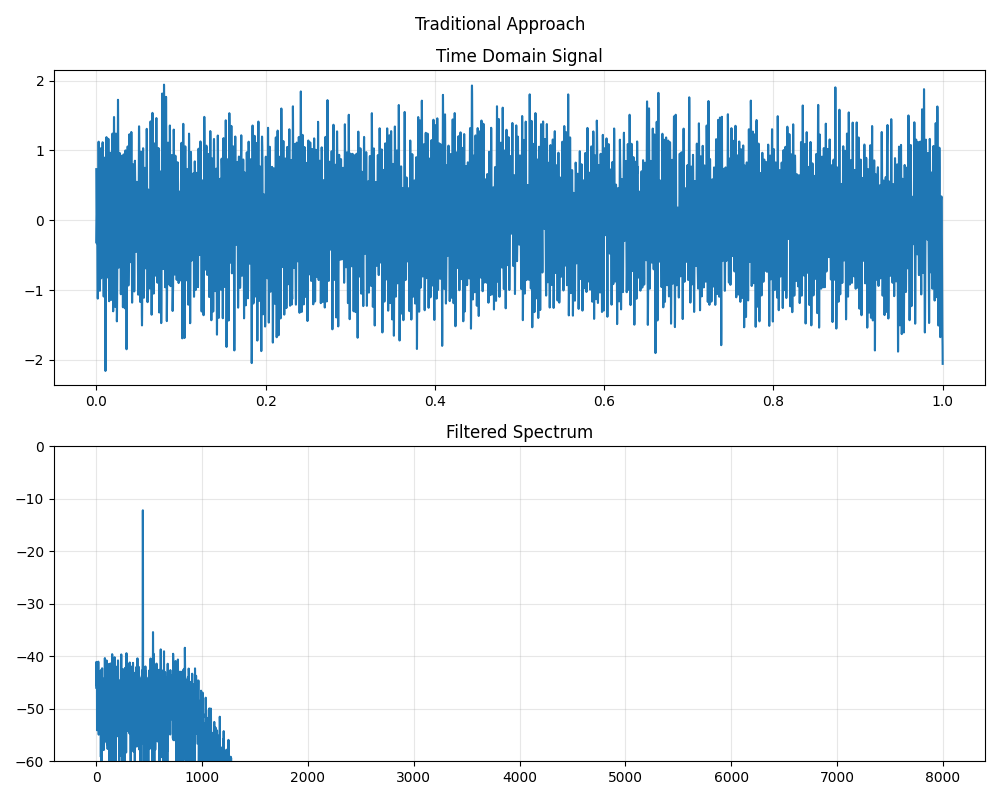

従来のアプローチでの処理が完了しました


In [20]:
# 従来のアプローチ：複数のライブラリを組み合わせる
import numpy as np
import scipy.signal

# データ生成（簡易のためWandasを使用）
sampling_rate = 16000
duration = 1.0
data = wd.generate_sin(freqs=[440], duration=1.0, sampling_rate=16000).data
t = np.arange(int(sampling_rate * duration)) / sampling_rate

# ランダムノイズを加える（Wandasのsignal += np.random.randn(signal.n_samples)と等価）
data += np.random.randn(len(data))

# フィルタリング
# バターワースフィルタを使用、カットオフ周波数1000Hz
b, a = scipy.signal.butter(4, 1000 / (sampling_rate / 2))  # 正規化周波数
filtered = scipy.signal.filtfilt(b, a, data)

# FFT
# Hann窓を適用
window = scipy.signal.windows.hann(len(filtered))
windowed = filtered * window
fft_result = np.fft.fft(windowed, norm='forward')
freqs = np.fft.fftfreq(len(data), 1/sampling_rate)

# 可視化
# 時間信号とスペクトルを並べて表示
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle("Traditional Approach")

# 時間信号のプロット
t = np.arange(len(filtered)) / sampling_rate
ax1.plot(t, filtered)
ax1.set(title='Time Domain Signal')
ax1.grid(True, alpha=0.3)

# dBスケールでスペクトルをプロット
magnitude_db = 20 * np.log10(np.abs(fft_result) + 1e-10)  # dB変換、小さな値を加えてlog(0)を避ける
ax2.plot(freqs[:len(freqs)//2], magnitude_db[:len(freqs)//2])
ax2.set(
    title='Filtered Spectrum',
    ylim=(-60, 0)
)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("従来のアプローチでの処理が完了しました")

## 🚀 Wandasの解決アプローチ

### Wandasの3つの柱

#### 1. **PandasライクなAPI**
```python
# Wandasのアプローチ：直感的なメソッドチェーン
import wandas as wd

# 読み込み → フィルタリング → FFT → 可視化
result = (
    wd.read_wav('signal.wav')
    .low_pass_filter(cutoff=1000)
    .fft()
    .plot(title='Filtered Spectrum')
)
```

**利点:**
- 直感的な操作
- メソッドチェーンで処理を連鎖
- pandasユーザーになじみやすい

/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


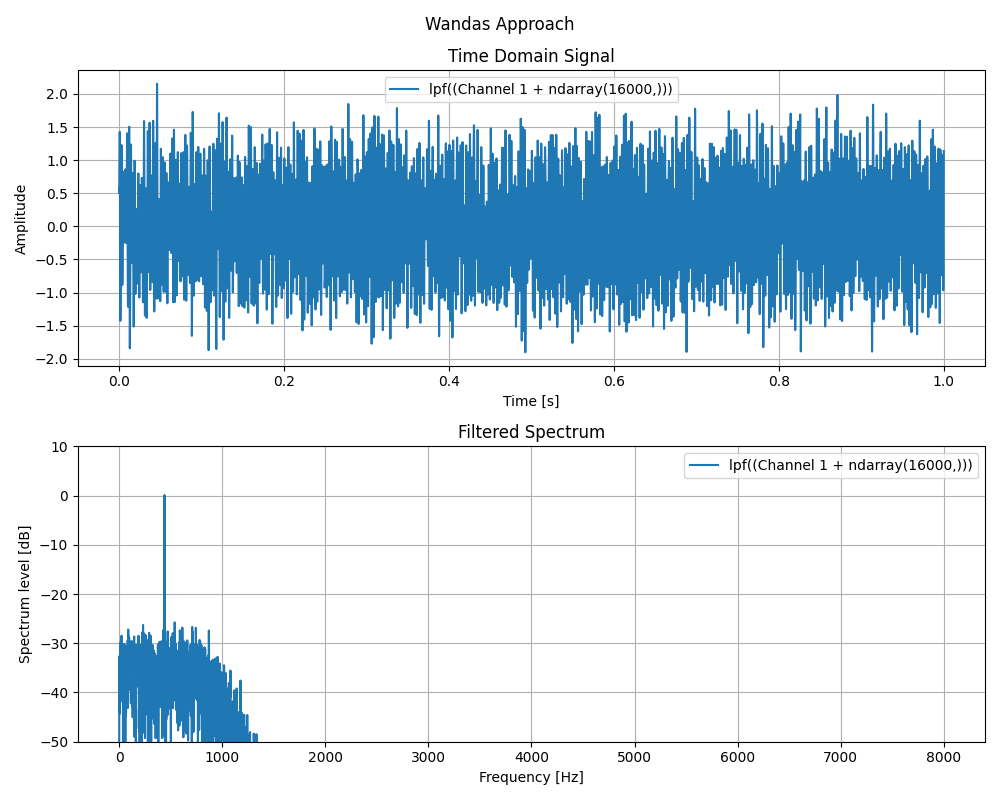

Wandasのアプローチでの処理が完了しました
Operation history (3):
1: + {'with': 'ndarray(16000,)'}
2: lowpass_filter {'params': {'cutoff': 1000, 'order': 4}}
3: fft {'params': {'n_fft': 16001, 'window': 'hann'}}


In [ ]:
# Wandasのアプローチ：直感的なメソッドチェーン

# 読み込み → フィルタリング → FFT → 可視化
# （実際のファイルがないので、サンプルデータで代用）
signal = wd.generate_sin(freqs=[440], duration=1.0, sampling_rate=16000)
# ランダムノイズを加える
signal += np.random.randn(signal.n_samples)

# フィルタリングとFFTをメソッドチェーンで実行
result = (
    signal
    .low_pass_filter(cutoff=1000)
    .fft()
)

# 可視化
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle("Wandas Approach")
result.previous.plot(ax=ax1, title='Time Domain Signal') # fft前の時系列信号
result.plot(ax=ax2, title='Filtered Spectrum', ylim=(-50, 10)) # fft後の周波数スペクトル
plt.tight_layout()
plt.show()
print("Wandasのアプローチでの処理が完了しました")
result.info()

#### 2. **統合されたデータ構造**

**ChannelFrame**: 信号データを統一的に扱う
- **多次元データ**: チャンネル × サンプルの2D配列
- **メタデータ**: サンプリングレート、チャンネル名、単位、処理履歴
- **型安全性**: mypy対応の厳格な型付け
- **遅延評価**: Daskによるメモリ効率的な処理

#### 3. **包括的な可視化**

**一つのメソッドで完全な分析**
```python
# 波形、スペクトル、スペクトログラムを一度に表示
signal.describe()
```

**特徴:**
- インタラクティブなプロット
- 出版品質のグラフ
- Matplotlib統合

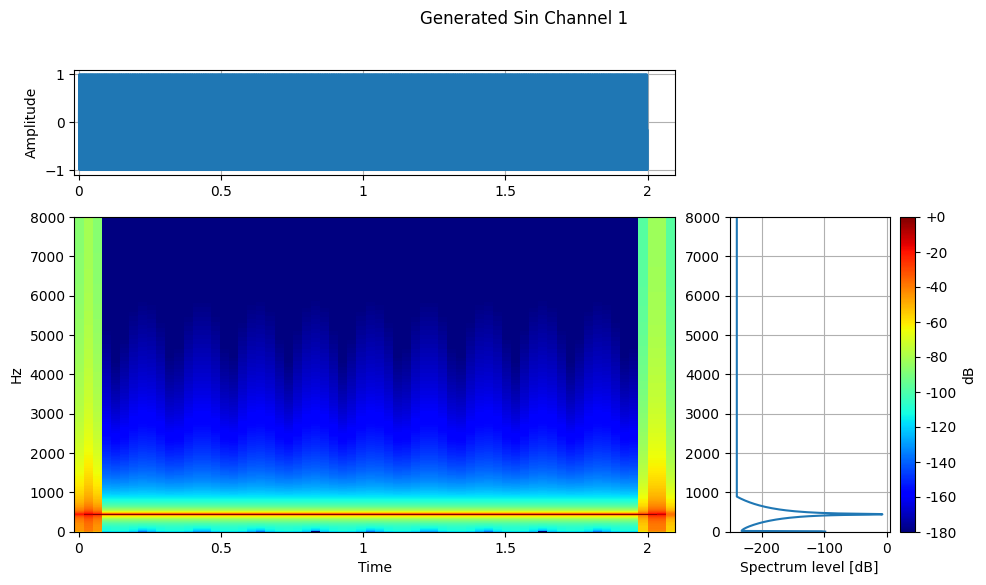

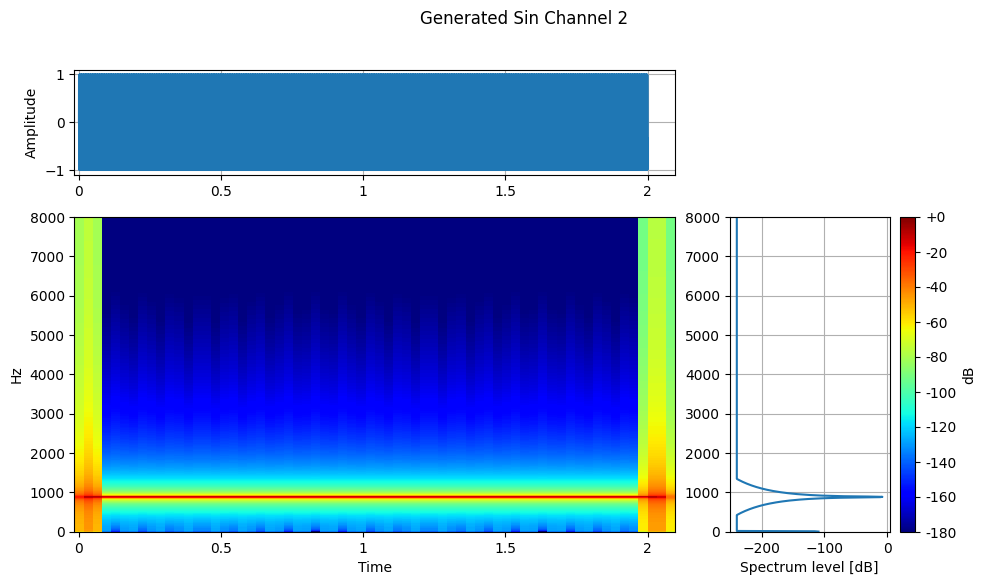

describe()メソッドで包括的な分析が表示されました
時間領域、スペクトル領域、スペクトログラムが一度に確認できます


In [22]:
# 一つのメソッドで完全な分析
# 波形、スペクトル、スペクトログラムを一度に表示
signal = wd.generate_sin(freqs=[440, 880], duration=2.0, sampling_rate=16000)
signal.describe()

print("describe()メソッドで包括的な分析が表示されました")
print("時間領域、スペクトル領域、スペクトログラムが一度に確認できます")

## 💡 Wandasが解決する具体的な問題

### ユースケース1: 環境音の分析

**課題:** 複数地点で録音した環境音を比較したいが、チャンネル管理が複雑

**Wandasでの解決:**
```python
# 複数チャンネルの環境音分析
recording = wd.read_wav('ambient_recording.wav')
# 全チャンネルにバンドパスフィルタを適用
filtered = recording.band_pass_filter(100, 8000)
# RMS値で音圧レベルを比較
rms_levels = filtered.rms
print(f"Sound pressure levels: {rms_levels}")
filtered.plot(title='Filtered Ambient Recording')
```

環境音データのシミュレーション:
チャンネル数: 3
チャンネル名: ['Location A', 'Location B', 'Location C']
各場所のA特性音圧レベル (RMS): [0.06457338 0.09697473 0.05176632]
環境音分析が完了しました


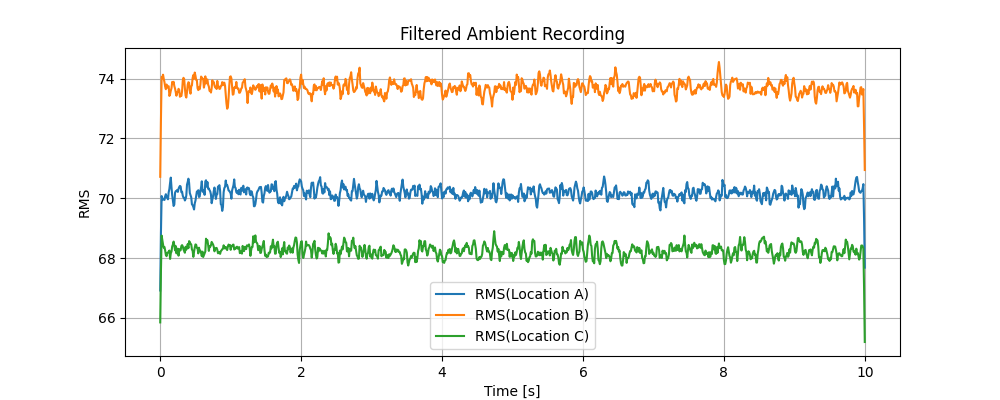

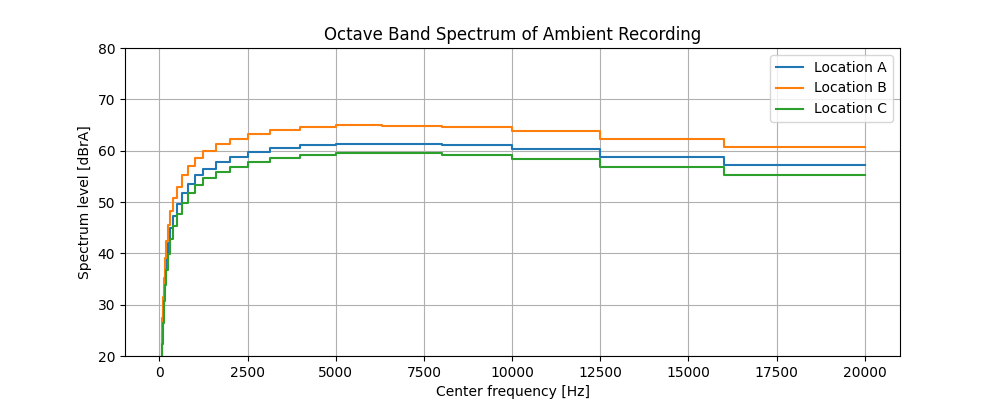

In [23]:
recording = wd.from_numpy(
    data=np.array([ch1_noise, ch2_noise, ch3_noise]),
    sampling_rate=fs,
    ch_labels=['Location A', 'Location B', 'Location C'],
    ch_units='Pa'
)

print("環境音データのシミュレーション:")
recording.info()

# RMS値で音圧レベルを比較
rms_levels = recording.a_weighting().rms
print(f"各場所のA特性音圧レベル (RMS): {rms_levels}")

# フィルタリング結果を可視化
recording.rms_plot(title='Filtered Ambient Recording', Aw=True)

# オクターブ解析
recording.noct_spectrum().plot(title='Octave Band Spectrum of Ambient Recording', Aw=True,overlay=True, ylim=(20, 80))

print("環境音分析が完了しました")

### ユースケース2: 機械学習向けデータ前処理

**課題:** フォルダに格納された大量のwavファイルを、MLモデルに入力するためにスペクトログラムを作成し、前処理を行う必要がある

**Wandasを使った実装:**
```python
# FrameDatasetで大量のwavファイルをバッチ処理
dataset = wd.ChannelFrameDataset.from_folder('audio_dataset/', lazy_loading=True)
# 前処理パイプライン（リサンプリング、トリミング、正規化）
dataset = (dataset
    .resample(target_sr=8000)  # サンプリングレート統一
    .trim(start=0, end=5)      # 長さ統一
    .normalize())              # 振幅正規化
# 全ファイルにSTFTを適用してスペクトログラムを作成
spectrograms = dataset.stft(n_fft=512, hop_length=256)
# MLモデルでの処理と結果確認
ml_results = spectrograms.apply(process_ml_function)
# ISTFTで時間領域に戻して処理結果を検証
reconstructed = ml_results.istft()
```

**このユースケースで学ぶこと:**
- 大規模データセットの効率的な処理方法
- ML向けのデータ前処理パイプライン
- スペクトログラムベースの特徴抽出
- 処理結果の検証

#### ステップ1: MLデータセットの準備

機械学習モデルをトレーニングするためには、大量のデータが必要です。ここでは、実際のwavファイルの代わりに、プログラムで様々な周波数特性を持つ音声ファイルを生成してデータセットを作成します。

In [24]:
# ユースケース2: 機械学習向けデータ前処理

import tempfile
import os
from pathlib import Path
import numpy as np
from wandas.utils.frame_dataset import ChannelFrameDataset, SpectrogramFrameDataset

# 大量のwavファイルをシミュレートするためのサンプルデータセットを作成
temp_dir = tempfile.mkdtemp()
print(f"サンプルデータセットを作成: {temp_dir}")

# 複数の音声ファイルを生成（MLデータセットのシミュレーション）
sampling_rate = 16000
duration = 10.0
n_files = 10  # 大量のファイルを想定

for i in range(n_files):
    # 異なる周波数特性を持つファイルを生成
    freqs = [440 + i * 100, 880 + i * 50]  # ファイルごとに異なる周波数
    audio = wd.generate_sin(
        freqs=freqs,
        duration=duration,
        sampling_rate=sampling_rate
    )
    # ノイズを加えて現実的なデータをシミュレート
    audio += np.random.randn(audio.n_samples) * 0.1

    filename = os.path.join(temp_dir, f"audio_sample_{i+1:03d}.wav")
    audio.to_wav(filename)

print(f"{n_files}個のサンプル音声ファイルを作成しました")


サンプルデータセットを作成: /tmp/tmp8l2skpxl
10個のサンプル音声ファイルを作成しました


#### ステップ2: データセットの読み込みと前処理

作成したデータセットをFrameDatasetで読み込み、MLモデルへの入力に適した形式に前処理します。

**前処理の内容:**
- **lazy_loading=True**: メモリ効率のため、データを必要になるまで読み込まない
- **resample()**: サンプリングレートを統一（MLモデルは固定レートを期待）
- **trim()**: 音声の長さを統一（バッチ処理のため）

**なぜ前処理が必要か:**
- MLモデルは入力データの形式が統一されていることを前提としている
- 異なるサンプリングレートや長さのデータを統一することで、バッチ処理が可能になる

データセット情報:
  ファイル数: 10
  サンプリングレート: 16000 Hz
  長さ: 10.0 秒
リサンプリング後のデータセット情報:
  データセットサイズ: 10
  サンプリングレート: 8000 Hz
  長さ: 5.0 秒
スペクトログラム作成完了:
  データセットサイズ: 10
  周波数ビン数: 257
  時間フレーム数: 158


/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


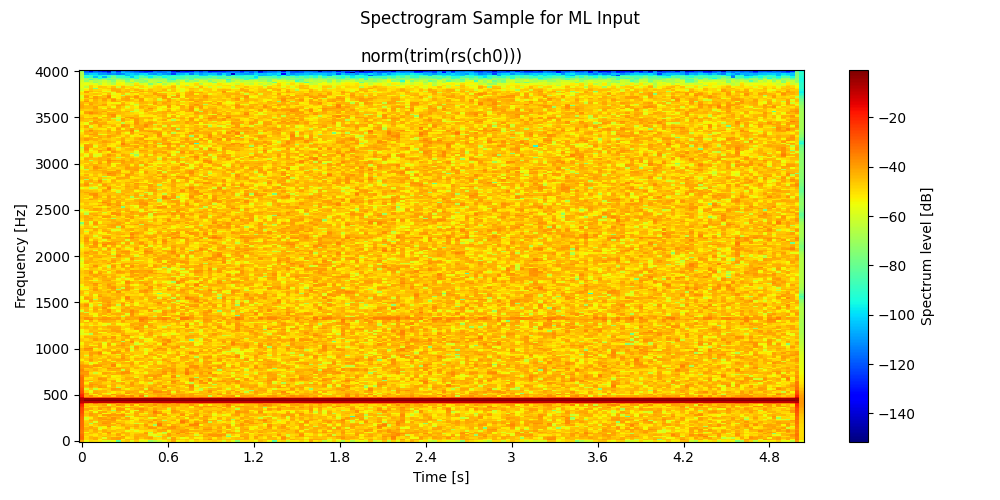

In [25]:
# FrameDatasetでフォルダからデータを読み込み
dataset = ChannelFrameDataset.from_folder(
    folder_path=temp_dir,
    lazy_loading=True  # メモリ効率のため遅延読み込み
)

print("データセット情報:")
print(f"  ファイル数: {len(dataset)}")
print(f"  サンプリングレート: {dataset[0].sampling_rate if dataset[0] else 'N/A'} Hz")
print(f"  長さ: {dataset[0].duration if dataset[0] else 'N/A'} 秒")

dataset = (dataset
    .resample(target_sr=8000)  # 必要に応じてリサンプリング
    .trim(start=0, end=5)  # 長さを指定
    .normalize() # 正規化
)
print("リサンプリング後のデータセット情報:")
print(f"  データセットサイズ: {len(dataset)}")
print(f"  サンプリングレート: {dataset[0].sampling_rate if dataset[0] else 'N/A'} Hz")
print(f"  長さ: {dataset[0].duration if dataset[0] else 'N/A'} 秒")

# 全ファイルにSTFTを適用してスペクトログラムを作成
spectrogram_dataset = dataset.stft(n_fft=512, hop_length=256)

print("スペクトログラム作成完了:")
print(f"  データセットサイズ: {len(spectrogram_dataset)}")
print(f"  周波数ビン数: {spectrogram_dataset[0].n_freq_bins if spectrogram_dataset[0] else 'N/A'}")
print(f"  時間フレーム数: {spectrogram_dataset[0].n_frames if spectrogram_dataset[0] else 'N/A'}")

# サンプルとして最初のスペクトログラムを表示
spectrogram_dataset[0][0].plot(title='Spectrogram Sample for ML Input')

#### ステップ3: スペクトログラム変換とML処理

前処理済みのデータをスペクトログラムに変換し、MLモデルでの処理をシミュレートします。

**STFT (Short-Time Fourier Transform) の役割:**
- 時間-周波数解析により、信号の時間変化を捉える
- MLモデル（CNNなど）は画像のような2Dデータを入力として扱いやすい
- n_fft=512: 周波数分解能と時間分解能のバランス
- hop_length=256: フレームのオーバーラップ（50%）

**ML処理のシミュレーション:**
- 実際のMLモデル（TensorFlow, PyTorchなど）にスペクトログラムを入力
- ここでは簡易的なノイズ除去を例として実装
- apply()メソッドでデータセット全体に処理を適用

Processing ML input with shape: (257, 158)


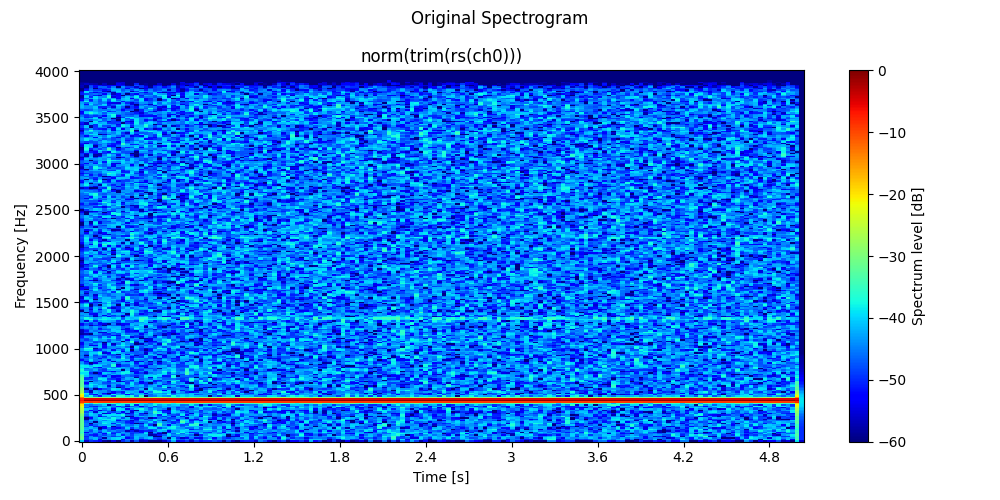

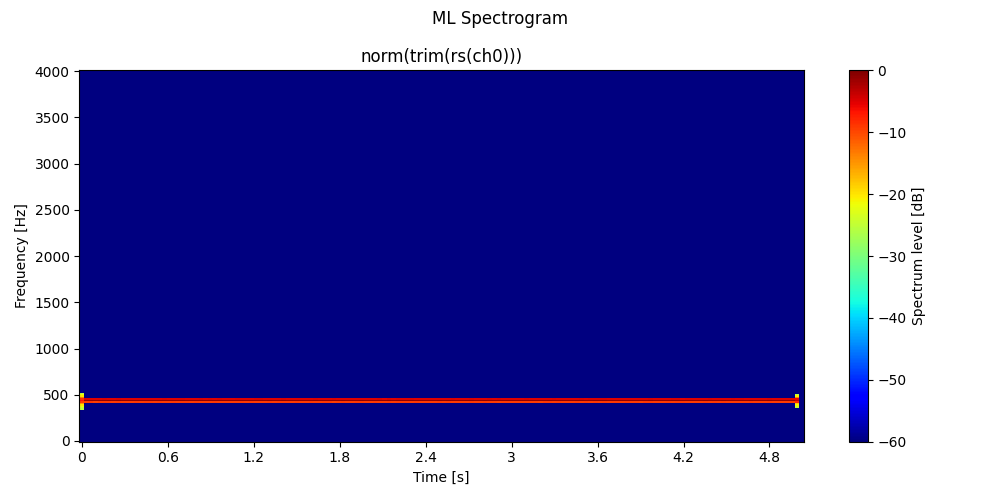

In [26]:
from wandas.frames.spectrogram import SpectrogramFrame
def process_ml(frame: SpectrogramFrame) -> SpectrogramFrame:
    # ダミー関数、実際にはMLモデルへの入力処理を実装
    previous = frame[0]
    print(f"Processing ML input with shape: {previous.shape}")

    data = previous.data

    # ここで実際のML処理を行う
    data[np.abs(data) < 0.05] = 0 # 簡易なノイズ除去
    ml_out_data = data

    # ML処理結果をSpectrogramFrameとして返す
    ml_out = SpectrogramFrame.from_numpy(
        data=ml_out_data,  # チャンネル次元を追加
        sampling_rate=frame.sampling_rate,
        n_fft=frame.n_fft,
        hop_length=frame.hop_length,
        win_length=frame.win_length,
        window=frame.window,
        label=f"ML({frame.label})",
        metadata=frame.metadata,
        operation_history=frame.operation_history,
        channel_metadata=[frame.channels[0]],
        previous=previous,
    )
    return ml_out

ml_results = spectrogram_dataset.apply(process_ml)
ml_results[0].previous.plot(vmin=-60, vmax=0, title='Original Spectrogram')
ml_results[0].plot(vmin=-60, vmax=0, title='ML Spectrogram')


#### ステップ4: 処理結果の検証

ML処理の結果をISTFT (Inverse STFT) で時間領域に戻し、処理前後の比較を行います。

**検証の重要性:**
- ML処理が信号の重要な特徴を保持しているか確認
- 処理結果が元の信号と整合性があるか検証
- describe()メソッドで包括的な分析（波形・スペクトル・スペクトログラム）

**ISTFTの役割:**
- 周波数領域の処理結果を時間領域に戻す
- 人間が聞き取りやすい形で結果を確認できる

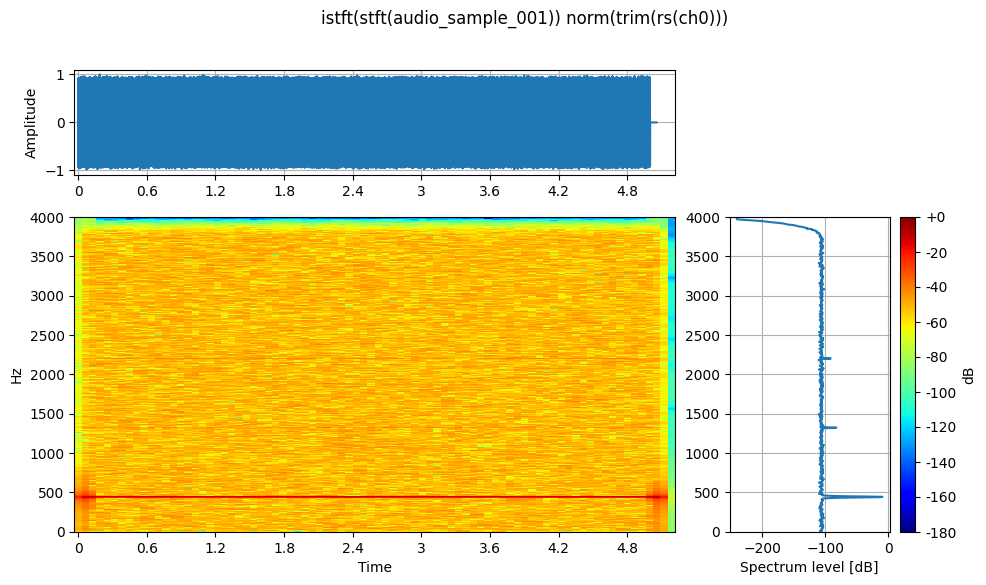

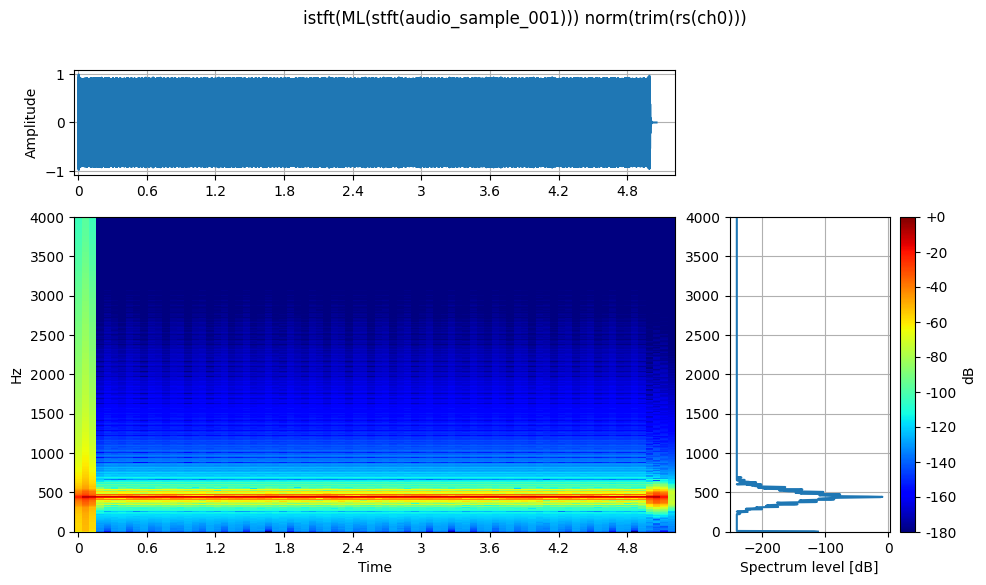

In [27]:
# ISTFTで時間信号に元して処理結果を確認
ml_results[0].previous.istft().describe()
ml_results[0].istft().describe()

#### ステップ5: リソースのクリーンアップ

一時的に作成したデータセットを削除し、リソースを解放します。


In [28]:
# クリーンアップ
import shutil
shutil.rmtree(temp_dir)
print(f"一時ディレクトリを削除: {temp_dir}")

一時ディレクトリを削除: /tmp/tmp8l2skpxl


### ユースケース3: 品質管理と異常検知

**課題:** 製造ラインの振動データを監視し、異常を検知したい

**Wandasでの解決:**
```python
# 振動データのバッチ処理と特徴抽出
dataset = wd.ChannelFrameDataset.from_folder('vibration_data/')
spectrograms = dataset.stft()
# スペクトル特徴に基づく異常検知
```

振動データの準備:
正常データ: (16000,)
異常データ: (16000,)
特徴抽出完了:
正常データ RMS: 0.033
異常データ RMS: 0.102
閾値: 0.067
⚠️ 異常が検知されました！


<Axes: title={'center': 'RMS Comparison'}, xlabel='Time [s]', ylabel='RMS'>

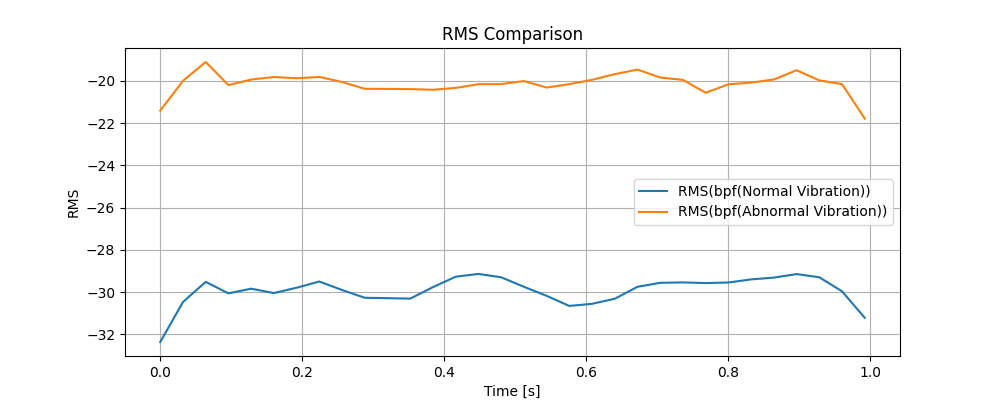

In [29]:
# 振動データのバッチ処理と特徴抽出

# 振動データをシミュレーション（正常データと異常データ）
np.random.seed(42)
normal_vibration = wd.from_numpy(
    data=np.random.randn(1, 16000) * 0.1,  # 正常振動（1秒間）
    sampling_rate=16000,
    ch_labels=['Normal Vibration']
)

abnormal_vibration = wd.from_numpy(
    data=np.random.randn(1, 16000) * 0.3 + np.sin(np.linspace(0, 4*np.pi, 16000)),  # 異常振動（1秒間）
    sampling_rate=16000,
    ch_labels=['Abnormal Vibration']
)

print("振動データの準備:")
normal_vibration.info()
abnormal_vibration.info()

# 特徴抽出（RMS値を使用）
def extract_features(vibration_data: wd.ChannelFrame) -> tuple[float, wd.ChannelFrame]:
    preprocessed = vibration_data.band_pass_filter(20, 1000)
    rms = preprocessed.rms
    return (rms[0], preprocessed)

normal_features, normal_preprocessed = extract_features(normal_vibration)
abnormal_features, abnormal_preprocessed = extract_features(abnormal_vibration)
print("特徴抽出完了:")
print(f"正常データ RMS: {normal_features:.3f}")
print(f"異常データ RMS: {abnormal_features:.3f}")

# 異常検知（簡易的な閾値ベース）
threshold = (normal_features + abnormal_features) / 2
print(f"閾値: {threshold:.3f}")

if abnormal_features > threshold:
    print("⚠️ 異常が検知されました！")
else:
    print("✅ 正常な状態です")

# 正常データと異常データの比較
ax = normal_preprocessed.rms_plot()
abnormal_preprocessed.rms_plot(ax=ax, title='RMS Comparison')

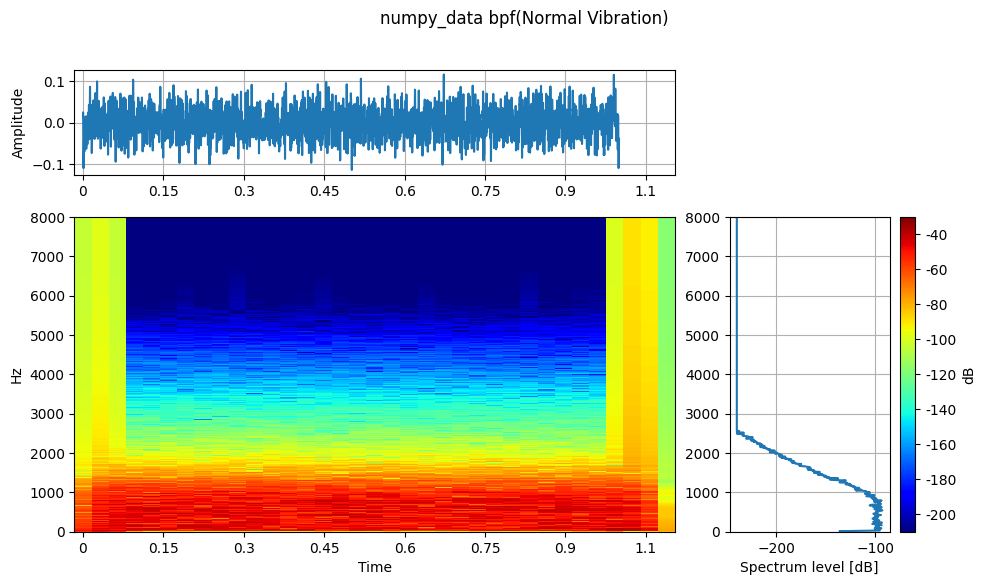

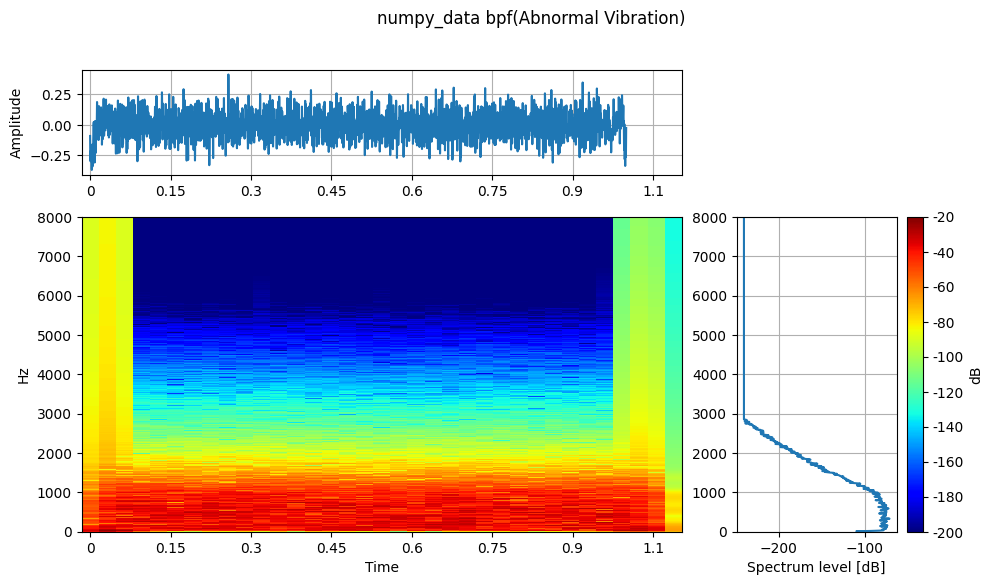

In [30]:
# データの詳細解析と視聴
normal_preprocessed.describe()
abnormal_preprocessed.describe()

## 🎨 Wandasの特徴を体験してみよう

### 最初のWandasコード

Wandasの便利さを一緒に確かめてみましょう。

In [31]:
# Wandasをインポート
import wandas as wd
import numpy as np
import matplotlib.pyplot as plt

# インタラクティブプロット設定
%matplotlib widget
plt.rcParams['figure.figsize'] = (10, 6)

print(f"Wandas version: {wd.__version__}")
print("Wandasが正常にインポートされました！")

Wandas version: 0.1.7
Wandasが正常にインポートされました！


In [ ]:
# サンプル信号を生成
signal = wd.generate_sin(
    freqs=[1000, 4000],
    duration=2.0,      # 2秒間
    sampling_rate=16000
)

print("生成された信号:")
signal.info()

生成された信号:
  チャンネル数: 2
  サンプリングレート: 16000 Hz
  長さ: 2.0 秒
  チャンネル名: ['Channel 1', 'Channel 2']


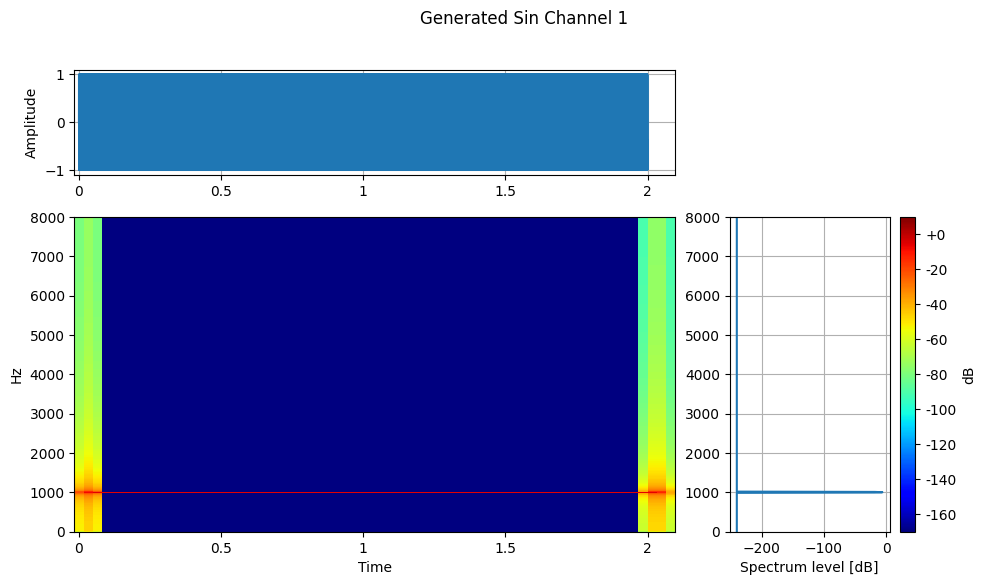

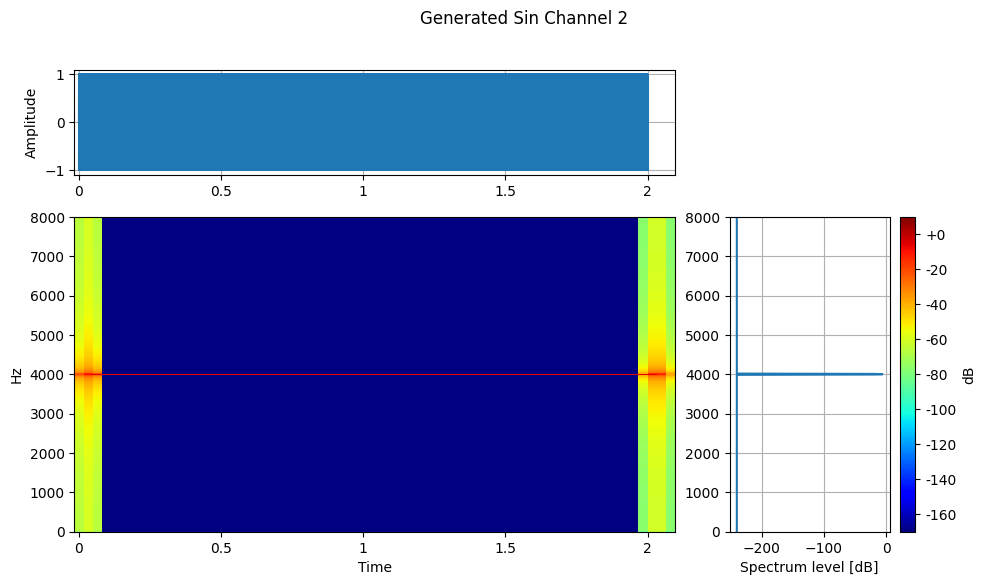

In [33]:
# Wandasのdescribe()メソッドで完全な分析を表示
signal.describe()

**🎉 たった1行のコードで:**
- 時間領域の波形
- 周波数領域のスペクトル
- 時間周波数領域のスペクトログラム

が一度に表示されました！

In [34]:
# メソッドチェーンで信号処理
processed = (
    signal
    .low_pass_filter(cutoff=2000)  # 660Hzローパスフィルタ
    .normalize()                   # 正規化
)

print("フィルタ処理が完了しました！")
print(f"処理履歴: {[op['operation'] for op in processed.operation_history]}")

フィルタ処理が完了しました！
処理履歴: ['lowpass_filter', 'normalize']


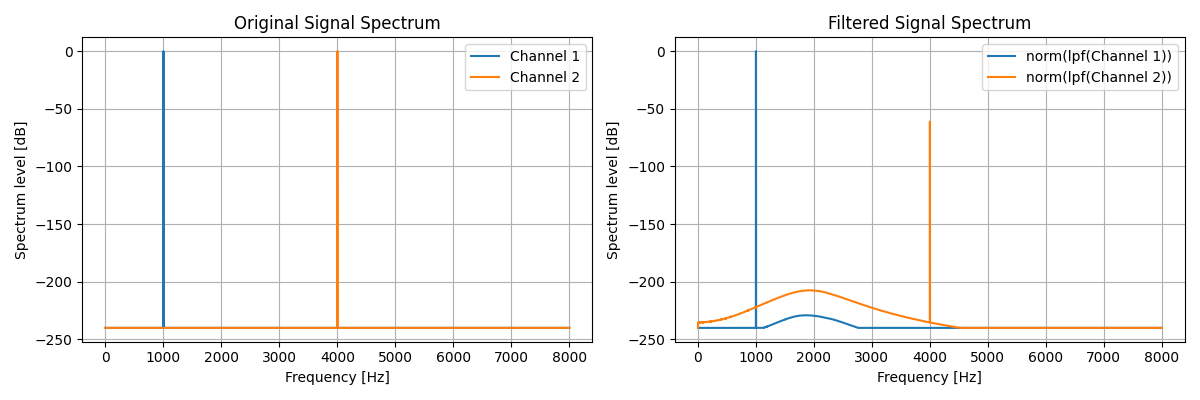

In [35]:
# 処理前後の比較
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 元の信号のスペクトル
signal.fft().plot(ax=ax1, title='Original Signal Spectrum')

# 処理後の信号のスペクトル
processed.fft().plot(ax=ax2, title='Filtered Signal Spectrum')

plt.tight_layout()
plt.show()

## 💡 Wandasを使うメリット

### 1. **生産性の向上**
- 信号処理パイプラインを効率的に構築
- 直感的なAPIで学習コストが低い
- 統合されたツールで作業がスムーズ

### 2. **信頼性の向上**
- 型安全性で実行時エラーを防ぐ
- 処理履歴で再現性を確保
- 包括的なテストで品質を保証

### 3. **拡張性の高さ**
- Dask統合で大規模データ対応
- モジュール化でカスタム処理を追加
- エコシステム統合（pandas, NumPy, Matplotlib）

### 4. **コミュニティとサポート**
- オープンソースで透明性が高い
- 活発な開発で継続的な改善
- 包括的なドキュメントで学習しやすい

## 🎯 こんな人におすすめ

### こんな方にぴったり
- **音響・振動エンジニア**: 測定データの効率的な分析をしたい
- **データサイエンティスト**: 信号処理をMLパイプラインに統合したい
- **研究者**: 再現可能で信頼性の高い分析を行いたい
- **学生**: 信号処理を直感的に学びたい

### すぐに始められる
- **Python経験者**: pandasやNumPyを知っていればOK
- **信号処理初心者**: 専門知識がなくても使える
- **大規模データユーザー**: Daskでメモリ効率的に処理

## 📚 次のステップ

Wandasの可能性を感じていただけましたか？

**次のノートブック**: [01_getting_started.ipynb](01_getting_started.ipynb)

ここでは実際にWandasをインストールし、環境を設定して、最初の信号処理を行ってみましょう。

---

**さあ、一緒に信号処理の世界を探索しましょう！** 🚀

質問があれば、[GitHub Issues](https://github.com/kasahart/wandas/issues) や [Discordコミュニティ](https://discord.gg/wandas) までお気軽にどうぞ。